# LowKey Experiments

## Import


In [54]:
import torch
import PIL
from PIL import Image
import numpy as np
from util.feature_extraction_utils import feature_extractor, normalize_transforms, warp_image, normalize_batch
from backbone.model_irse import IR_50, IR_101, IR_152
from backbone.model_resnet import ResNet_50, ResNet_101, ResNet_152
from util.attack_utils import  Attack
from util.prepare_utils import prepare_models, prepare_dir_vec, get_ensemble, prepare_data
from align.detector import detect_faces
from align.align_trans import get_reference_facial_points, warp_and_crop_face
import argparse
import matplotlib.pyplot as plt
import copy
import torchvision.transforms as transforms
import sys, os
import time 
import my_utils
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.transforms as transforms

to_tensor = transforms.ToTensor()

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


# Dataset preparation

### Cropping images

In [55]:
source_dir = './my_dataset/original'
face_dir = './my_dataset/faces'

In [56]:

if os.path.exists(face_dir):
    os.system('rm -rf ' + face_dir)

my_utils.crop_dataset(source_dir, face_dir)

### Creating attacked dataset

In [57]:
attack_dir = './my_dataset/attacked'

In [58]:
if os.path.exists(attack_dir):
    os.system('rm -rf ' + attack_dir)

my_utils.attack_dataset(face_dir, attack_dir, batch = 8)

Using default models
Loading Attack Backbone Checkpoint:
	IR_152: models/Backbone_IR_152_Arcface_Epoch_112.pth
	IR_152: models/Backbone_IR_152_Cosface_Epoch_70.pth
	ResNet_152: models/Backbone_ResNet_152_Arcface_Epoch_65.pth
	ResNet_152: models/Backbone_ResNet_152_Cosface_Epoch_68.pth
--------------------



In [59]:
X, Y = my_utils.get_dataset(face_dir)
X_attacked, Y_attacked = my_utils.get_dataset(attack_dir)

## Comparing the original and attacked images

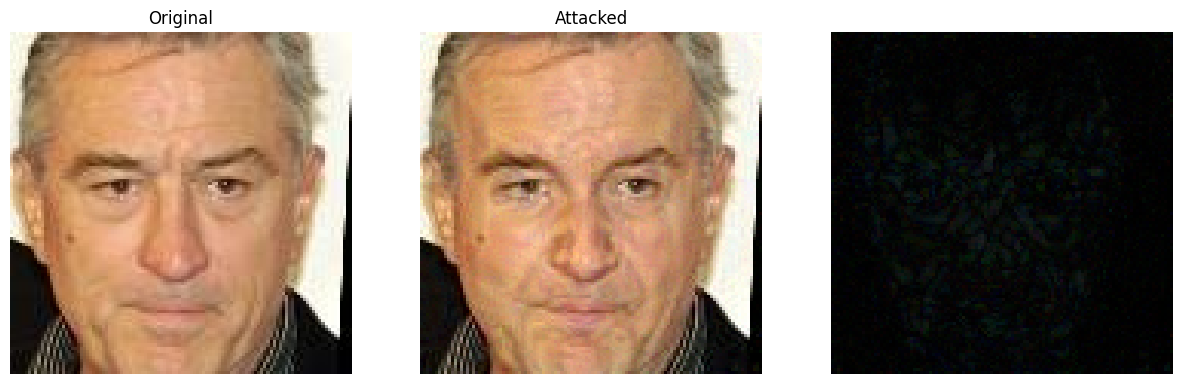

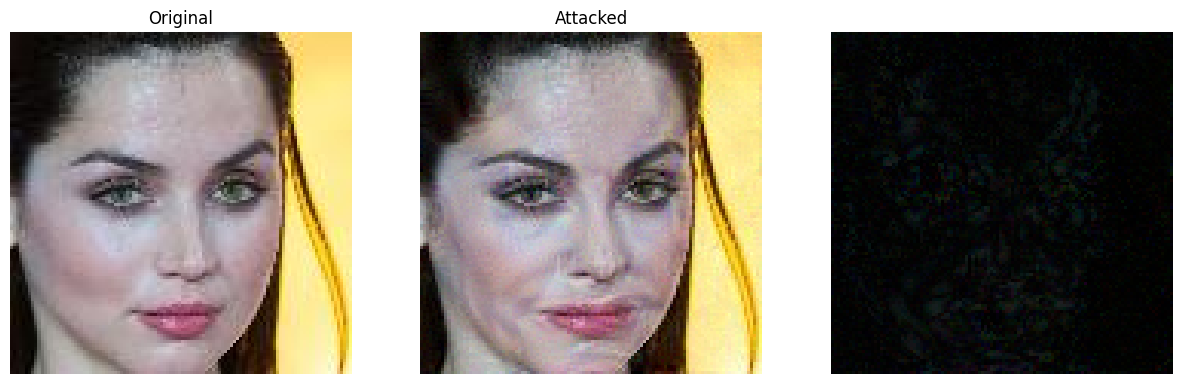

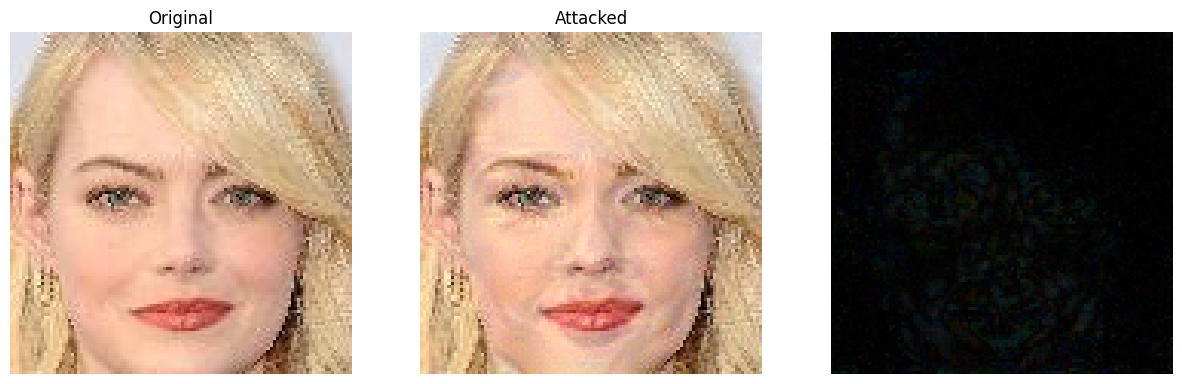

In [60]:
idx = np.random.randint(0, len(X), 3)

for i in range(3):
	face = cv2.imread(X[idx[i]])
	attacked = cv2.imread(X_attacked[idx[i]])
	
	fig, ax = plt.subplots(1, 3, figsize=(15, 15))
	
	for i in range(3):
		ax[i].set_axis_off()

	ax[0].imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
	ax[0].set_title("Original")
	ax[1].imshow(cv2.cvtColor(attacked, cv2.COLOR_BGR2RGB))
	ax[1].set_title("Attacked")

	difference = cv2.absdiff(face, attacked)
	ax[2].imshow(difference)
plt.show()

# Facial recognition

## Model

In [73]:
model_name = "ir152"
model_path = "models/Backbone_IR_152_Arcface_Epoch_112.pth"
model = my_utils.get_model(model_name, model_path).eval()

In [74]:
# Define batch size
batch_size = 8

# Split the attacked dataset into gallery and probe sets
_, _, gallery, Y_gallery = my_utils.my_split(X_attacked, Y_attacked)

# Extract features for the gallery set
X_gallery = my_utils.extract_features(model, gallery, batch_size)

# Split the original dataset into probe set
probe, Y_probe, clean_gallery, Y_clean_gallery = my_utils.my_split(X, Y)

# Extract features for the probe set
X_probe = my_utils.extract_features(model, probe, batch_size)

# Extract features for the clean gallery set
X_clean_gallery = my_utils.extract_features(model, clean_gallery, batch_size)


print("Gallery shape: ", X_gallery.shape)
print("Probe shape: ", X_probe.shape)

Gallery shape:  (101, 512)
Probe shape:  (24, 512)


In [75]:
# Import KNN classifier from scikit-learn
from sklearn.neighbors import KNeighborsClassifier

# Create KNN classifier for attacked dataset
knn_attacked = KNeighborsClassifier(n_neighbors=3)
knn_attacked.fit(X_gallery, Y_gallery)

# Predict labels for probe set using attacked dataset
Y_pred_attacked = knn_attacked.predict(X_probe)

# Calculate accuracy for attacked dataset
accuracy_attacked = np.mean(Y_pred_attacked == Y_probe)
print("Accuracy for attacked dataset: ", accuracy_attacked)

# Create KNN classifier for clean gallery dataset
knn_clean = KNeighborsClassifier(n_neighbors=3)
knn_clean.fit(X_clean_gallery, Y_clean_gallery)

# Predict labels for probe set using clean gallery dataset
Y_pred_clean = knn_clean.predict(X_probe)

# Calculate accuracy for clean gallery dataset
accuracy_clean = np.mean(Y_pred_clean == Y_probe)
print("Accuracy for clean gallery dataset: ", accuracy_clean)


Accuracy for attacked dataset:  0.08333333333333333
Accuracy for clean gallery dataset:  1.0
